In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

print(tf.__version__)

2.1.0


# Dataset

In [2]:
(x,labels), _ = tf.keras.datasets.cifar10.load_data()

x = np.asarray(x, dtype=np.float32)
x = x/255.0

ds = tfds.load('cifar10', split='train', as_supervised=True)

In [3]:
x.shape

(50000, 32, 32, 3)

# Model

## Using Sequential API

In [4]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, InputLayer

model1 = tf.keras.Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(10))

print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [5]:
model1.layers

In [6]:
model1.predict(x).shape

(50000, 10)

In [7]:
# One can call the model with some data (numpy)
model1(x[:5]).shape

TensorShape([5, 10])

In [50]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(x, labels, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 158us/sample - loss: 1.4932 - accuracy: 0.4574
Epoch 2/10
50000/50000 [==============================] - 7s 145us/sample - loss: 1.1368 - accuracy: 0.5971
Epoch 3/10
50000/50000 [==============================] - 7s 144us/sample - loss: 1.0028 - accuracy: 0.6469
Epoch 4/10
50000/50000 [==============================] - 8s 151us/sample - loss: 0.9100 - accuracy: 0.6797
Epoch 5/10
50000/50000 [==============================] - 8s 151us/sample - loss: 0.8381 - accuracy: 0.7060
Epoch 6/10
50000/50000 [==============================] - 8s 152us/sample - loss: 0.7838 - accuracy: 0.7255
Epoch 7/10
50000/50000 [==============================] - 7s 148us/sample - loss: 0.7338 - accuracy: 0.7434
Epoch 8/10
50000/50000 [==============================] - 7s 149us/sample - loss: 0.6886 - accuracy: 0.7589
Epoch 9/10
50000/50000 [==============================] - 8s 151us/sample - loss: 0.6469 - accuracy: 0.7719
Epoch

## Using functional API

In [30]:
from tensorflow.keras.layers import Input

conv1_layer = Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))
max1_layer = MaxPooling2D((2, 2))
covn2_layer = Conv2D(64, (3, 3), activation='relu')
max2_layer = MaxPooling2D((2, 2))
conv3_layer = Conv2D(64, (3, 3), activation='relu')

flatten_layer =Flatten()
dense_layer = Dense(64, activation='relu')
logits_layer = Dense(10)


input_tensor = Input(shape=(32,32,3))
img = conv1_layer(input_tensor)
img = max1_layer(img)
img = covn2_layer(img)
img = max2_layer(img)
img = conv3_layer(img)
img = flatten_layer(img)
img = dense_layer(img)
output_tensor = logits_layer(img)

model1_bis = Model(inputs=[input_tensor], outputs=[output_tensor])

# Model2 - ResNet50

In [8]:
model2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

In [9]:
model2.trainable = False

In [10]:
model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

One should not feeforward model2 with CIFAR2, but it is possible


In [14]:
model2(x[:5]).shape

TensorShape([5, 1, 1, 2048])

# model_resize

In [13]:
#
# 32,32,3 --> model_resize -> 224, 224,3

from tensorflow.keras.layers import Lambda

model_resize = tf.keras.Sequential(
    [
        Lambda(lambda image: tf.image.resize(image, size=(224,224)), input_shape=(32,32,3))
        # TODO: add preprocessing layer
    ]
)
        
model_resize.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


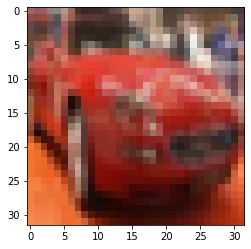

In [27]:
import matplotlib
from matplotlib import pyplot as plt

plt.imshow(x[5])

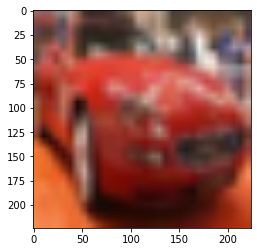

In [28]:
x_resized = model_resize(x[:6])

plt.imshow(x_resized.numpy()[5])

# Final model

## Using `input_tensor`

In [19]:
model3 = tf.keras.applications.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_tensor=model_resize.output  # we give the output of model_resize as an input_tensor for model3
)
# but the input of model3 will be the input of model_resize

In [20]:
model3.input, model_resize.input

(<tf.Tensor 'lambda_input:0' shape=(None, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'lambda_input:0' shape=(None, 32, 32, 3) dtype=float32>)

In [23]:
model3.predict(x[:5])

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.24339604e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.77415168e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.47369230e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.57356262e-03, ...,
          2.17818165e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.76410627e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.36338472e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.25929689e+00, 0.00000000e+00, 0.00000000e+00],
        

## Using functional api

In [26]:
from tensorflow.keras.models import Model
# First we take some tensor (namely the output of model_resize)
img = model_resize.output
# ... build new ones using tf.____ functions
output = model2(img)
model3_bis = Model(inputs=[model_resize.input], outputs=[output])

model3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lambda_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           lambda_input[0][0]               
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
___________________________________________________________________________________________

In [24]:
model3_bis.predict(x[:5])

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.24339604e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.77415168e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.47369230e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.57356262e-03, ...,
          2.17818165e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.76410627e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.36338472e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.25929689e+00, 0.00000000e+00, 0.00000000e+00],
        

In [25]:
model3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lambda_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           lambda_input[0][0]               
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
___________________________________________________________________________________________

In [186]:
features = model2.predict( x[:5000], verbose=1 )

5000/5000 [==============================] - 37s 7ms/sample


In [187]:
features.shape

(5000, 7, 7, 2048)

In [91]:
conv1_layer = Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))
max1_layer = MaxPooling2D((2, 2))
covn2_layer = Conv2D(64, (3, 3), activation='relu')
max2_layer = MaxPooling2D((2, 2))
conv3_layer = Conv2D(64, (3, 3), activation='relu')

flatten_layer =Flatten()
dense_layer = Dense(64, activation='relu')
logits_layer = Dense(10)


input_tensor = Input(shape=(32,32,3))
img = conv1_layer(input_tensor)
img = max1_layer(img)
img = covn2_layer(img)
img = max2_layer(img)
img = conv3_layer(img)
img = flatten_layer(img)
img = dense_layer(img)
output_tensor = logits_layer(img)

model3 = Model(inputs=[input_tensor], outputs=[output_tensor])